In [2]:
# Import usefull libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from helpers import corrX, cross_val_print_f1
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier , plot_importance


# Import datasets, concat and drop unneeded features
mqtt_bruteforce = pd.read_csv('datasets/uniflow_mqtt_bruteforce.csv')
normal = pd.read_csv('datasets/uniflow_normal.csv')
scan_A = pd.read_csv('datasets/uniflow_scan_A.csv')
scan_sU = pd.read_csv('datasets/uniflow_scan_sU.csv')
sparta = pd.read_csv('datasets/uniflow_sparta.csv')

data = pd.concat([mqtt_bruteforce, normal, scan_A, scan_sU, sparta], axis=0)
data.drop(['ip_src', 'ip_dst', 'prt_src', 'prt_dst', 'proto'], axis='columns', inplace=True)

# Dataset analysis

In [2]:
data.describe()

,num_pkts,mean_iat,std_iat,min_iat,max_iat,mean_pkt_len,num_bytes,num_psh_flags,num_rst_flags,num_urg_flags,std_pkt_len,min_pkt_len,max_pkt_len,is_attack
count,495525.000000,495525.000000,495525.000000,495525.000000,495525.000000,495525.000000,4.955250e+05,495525.000000,495525.000000,495525.000000,495525.000000,495525.000000,495525.000000,495525.000000
mean,64.824770,3.622589,2.642063,2.447903,13.791429,62.382303,7.223493e+03,24.560226,0.826138,0.000270,19.517398,51.097890,118.046050,0.240833
std,228.656594,89.445992,28.966512,85.239489,108.500546,22.007671,1.970592e+05,79.620701,4.666768,0.046206,44.027558,9.754169,176.278724,0.427590
min,1.000000,0.000000,0.000000,0.000000,0.000000,28.000000,2.800000e+01,0.000000,0.000000,0.000000,0.000000,28.000000,28.000000,0.000000
25%,5.000000,0.000256,0.000221,0.000002,0.000542,54.400000,2.720000e+02,1.000000,0.000000,0.000000,3.200000,52.000000,60.000000,0.000000
50%,5.000000,0.000370,0.000375,0.000004,0.000962,54.400000,2.720000e+02,1.000000,0.000000,0.000000,3.200000,52.000000,60.000000,0.000000
75%,7.000000,0.000628,0.000670,0.000007,0.001728,66.142857,4.640000e+02,3.000000,0.000000,0.000000,17.203464,52.000000,102.000000,0.000000
max,73552.000000,5995.716184,2871.311121,5995.716184,5995.716184,1344.000000,9.885389e+07,496.000000,51.000000,8.000000,255.453535,1344.000000,1344.000000,1.000000


## Data Contents
1. **Number of Packets in the flow** (num_pkts)
2. **Average inter arrival time** (mean_iat)
3. **Standard deviation of inter arrival time** (std_iat)
4. **Minimum inter arrival time** (min_iat)
5. **Maximum inter arrival time** (max_iat)
6. **Number of bytes** (num_bytes)
7. **Number of push flag** (num_psh_flags)
8. **Number of reset flag** (num_rst_flags)
9. **Number of urgent flag** (num_urg_flags)
10. **Average packet length** (mean_pkt_len)
11. **Standard deviation packet length** (std_pkt_len)
12. **Minimum packet length** (min_pkt_len)
13. **Maximum packet length** (max_pkt_len)

- Dataset checked for NaN values 
- Dataset is not going to be checked for duplicates because of the nature of the problem, the entries are real data that coincidentally have values that are identical
- Dataset checked for the imbalance between classes and observed that there is a noticable difference between malicious and normal flows

In [3]:
data.isna().sum().sum()


0

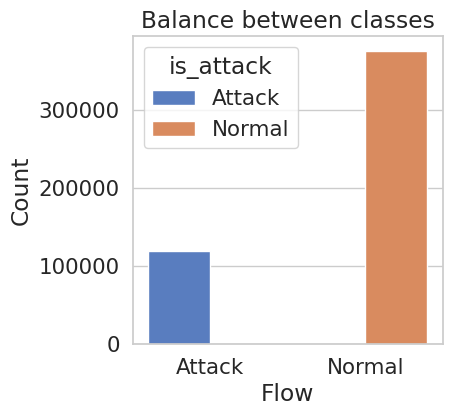

In [3]:
data['is_attack'] = data['is_attack'].map({0: 'Normal', 1: 'Attack'})
sns.set(style="whitegrid", palette="muted",font_scale = 1.4)
plt.figure(figsize=(4, 4))  # Optional: Set figure size
sns.countplot(x='is_attack', data=data, hue=data['is_attack'])
plt.xlabel("Flow")
plt.ylabel("Count")
plt.title("Balance between classes")
plt.show()

## Visualization
The separability should be as high as possible so that the features provide good information for classification (and clustering) in the machine learning models that will be built afterwards. 


Conclusions:
- There is not so much separability in the distributions between the  values of malicious and normal flows for each feature


When it's observed that features have very different distributions. Normalization is needed before the violin and swarm plots, because the differences between feature values are too high to be seen in the plots. 


Also some machine learning methods give better results if the data is normalised


In this notebook it will be used the `normalize` from `preprocessing` of `scikit-learn` library, that is converting the data in the interval of $[-1, 1]$

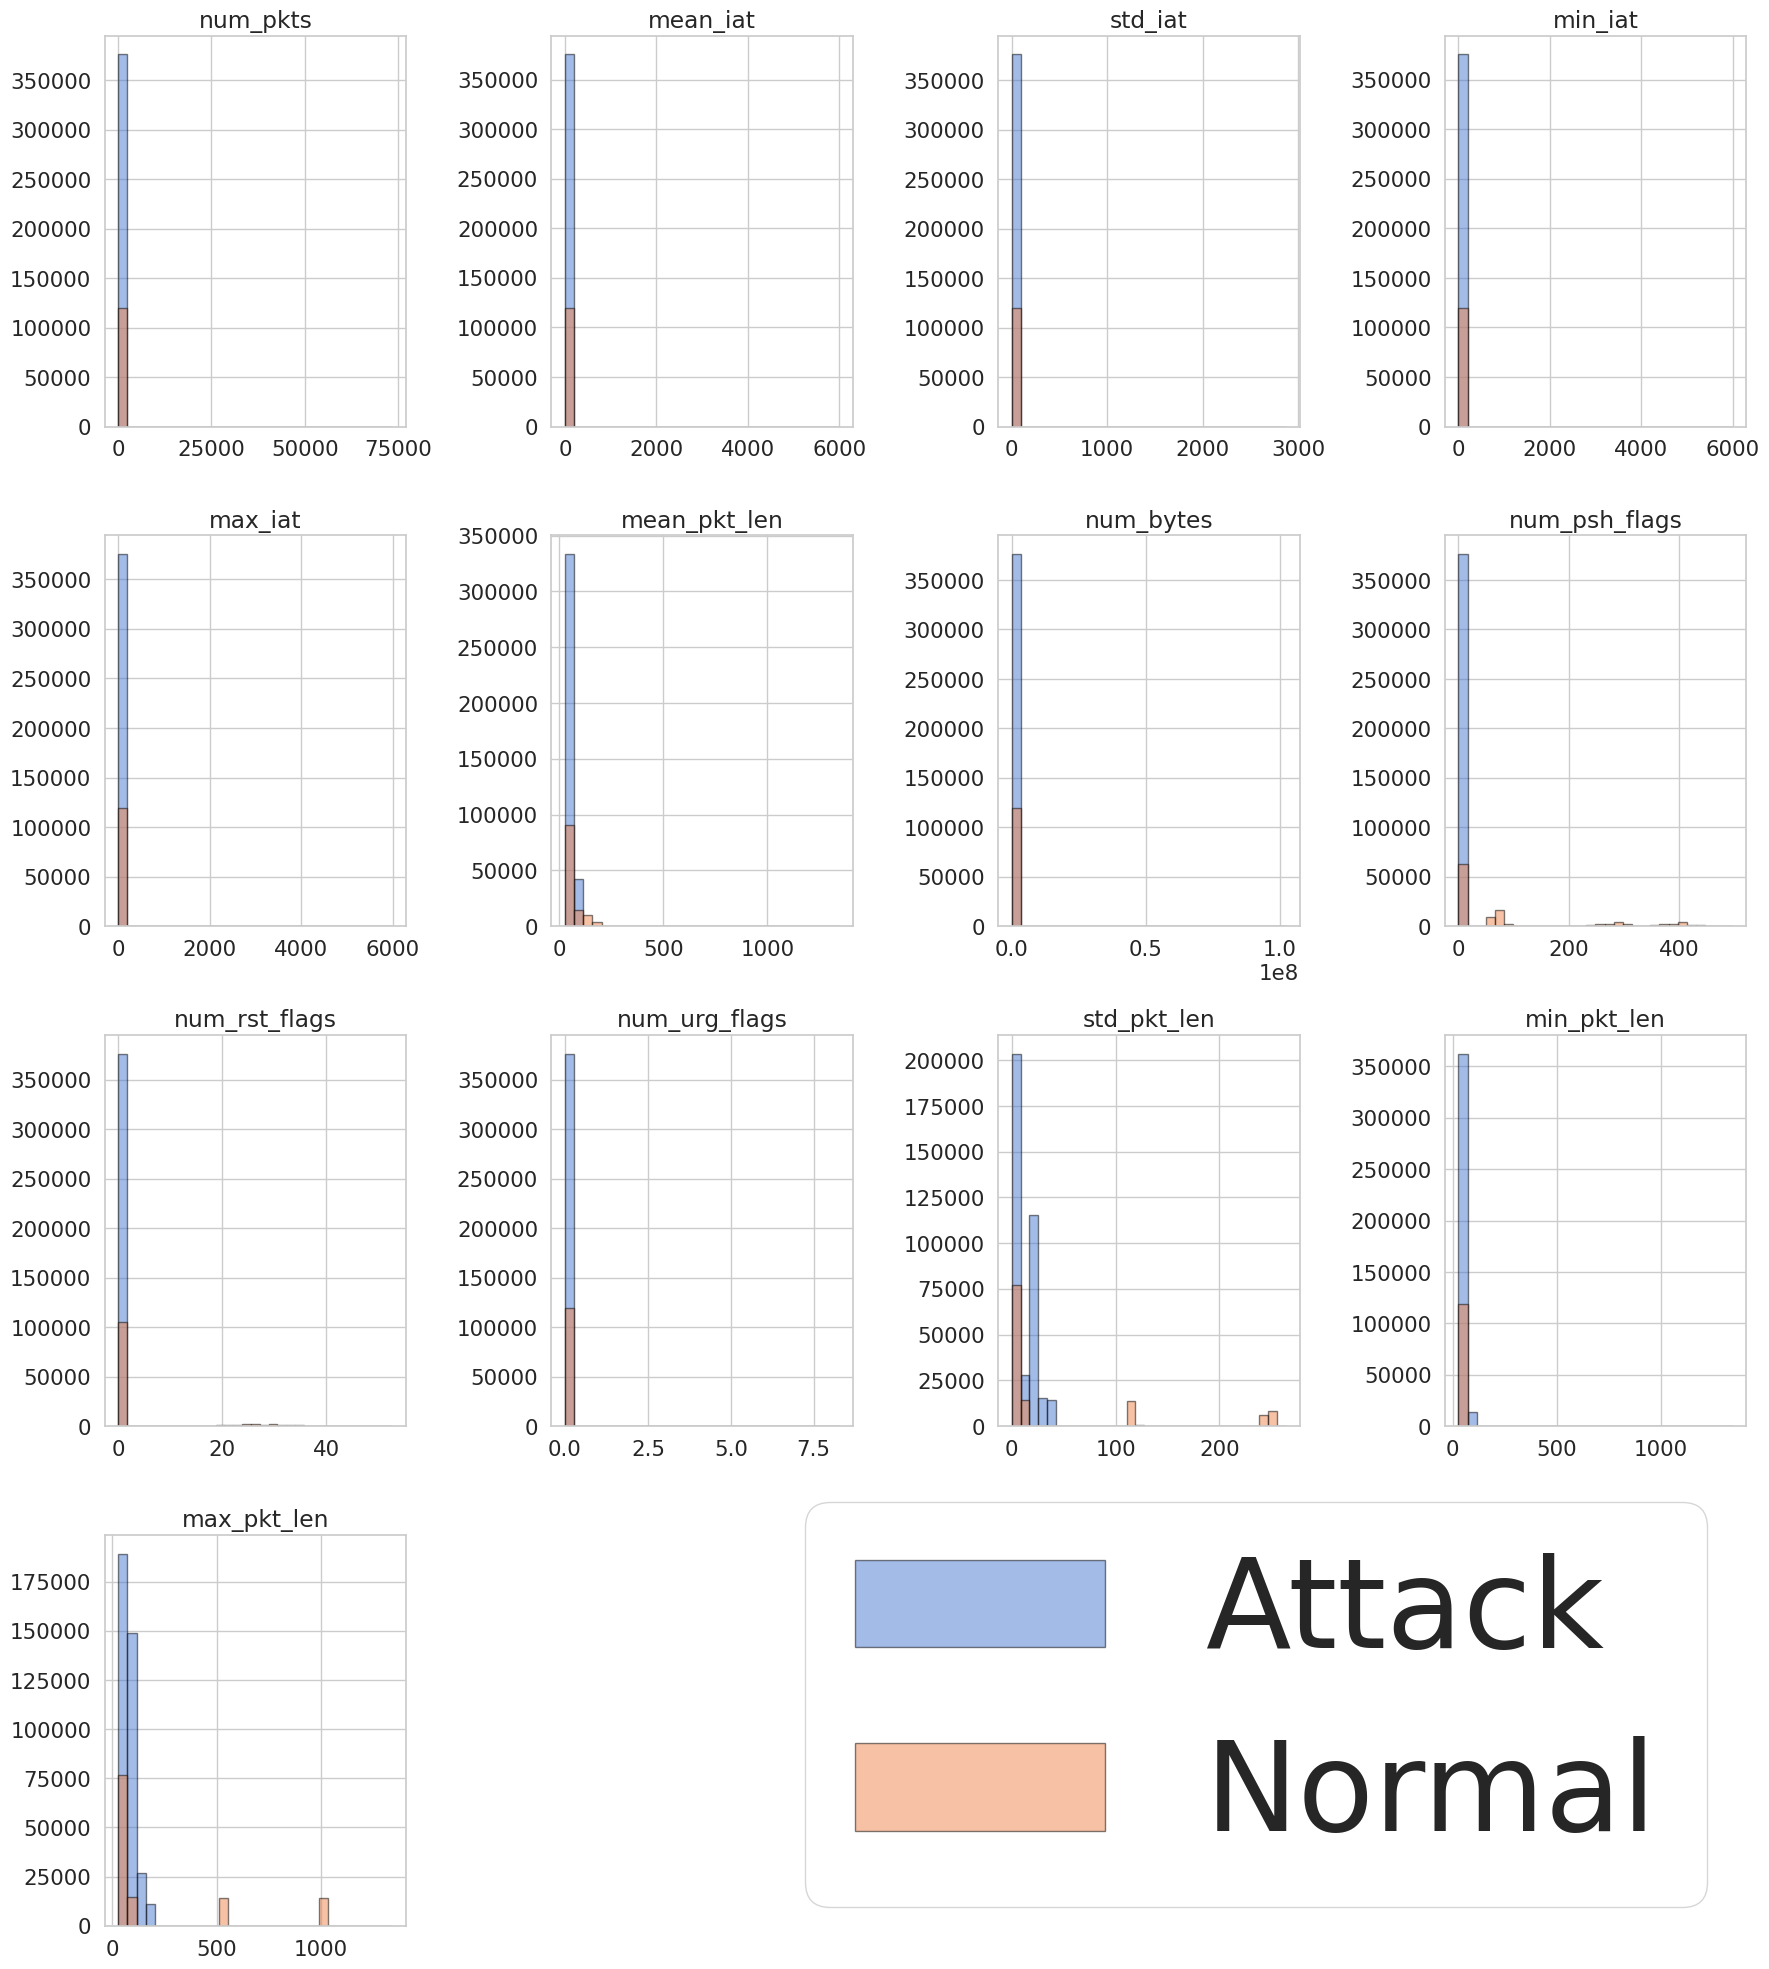

In [5]:
# plot distribution
# to see how distribution is in regard to the flow, we need to first split the dataset into two groups
malicious = data[data['is_attack'] =='Attack']
normal = data[data['is_attack'] =='Normal']

# also bring features back, basically redefining them again
features = list(data.columns[0:-1])
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18,20))
axes = axes.ravel()

for i,plot1 in enumerate(axes):
    if i < 13:    
        binwidth = (max(data[features[i]]) - min(data[features[i]])) / 30
        bins = np.arange(min(data[features[i]]), max(data[features[i]]) + binwidth, binwidth)

        # Plot normal and malicious histograms
        _, bins, _ = plot1.hist(normal[features[i]], bins=bins, alpha=0.5, density=False, stacked=True,
                                edgecolor="black", label='Normal')
        _, _, _ = plot1.hist(malicious[features[i]], bins=bins, alpha=0.5, density=False, stacked=True,
                            edgecolor="black", label='Attack')
        plot1.set_title(features[i])
    else:
        fig.delaxes(axes[i])

fig.legend(loc='lower right', labels=['Attack', 'Normal'], prop={'size': 90})        
plt.tight_layout()
plt.show()

### Visualisation on Scaled data
- Seaborn will be used in order to visualize the data and show the diversity of the graphs.
- The features are drawn in $3$ groups to make them easier to observe.

Finding of correlation heatmap:
- `minimum` and `maximum` values have either $1.0$ or $0.9$ correlation with mean on `packet length` and `inter arrival time` respectively

In [3]:
y = data.is_attack
x = data.drop('is_attack',axis = 1)
scaled_x = pd.DataFrame(preprocessing.normalize(x), columns=x.columns)
scaled_x = scaled_x.reset_index(drop=True) 
y = y.reset_index(drop=True)
x = x.reset_index(drop=True)

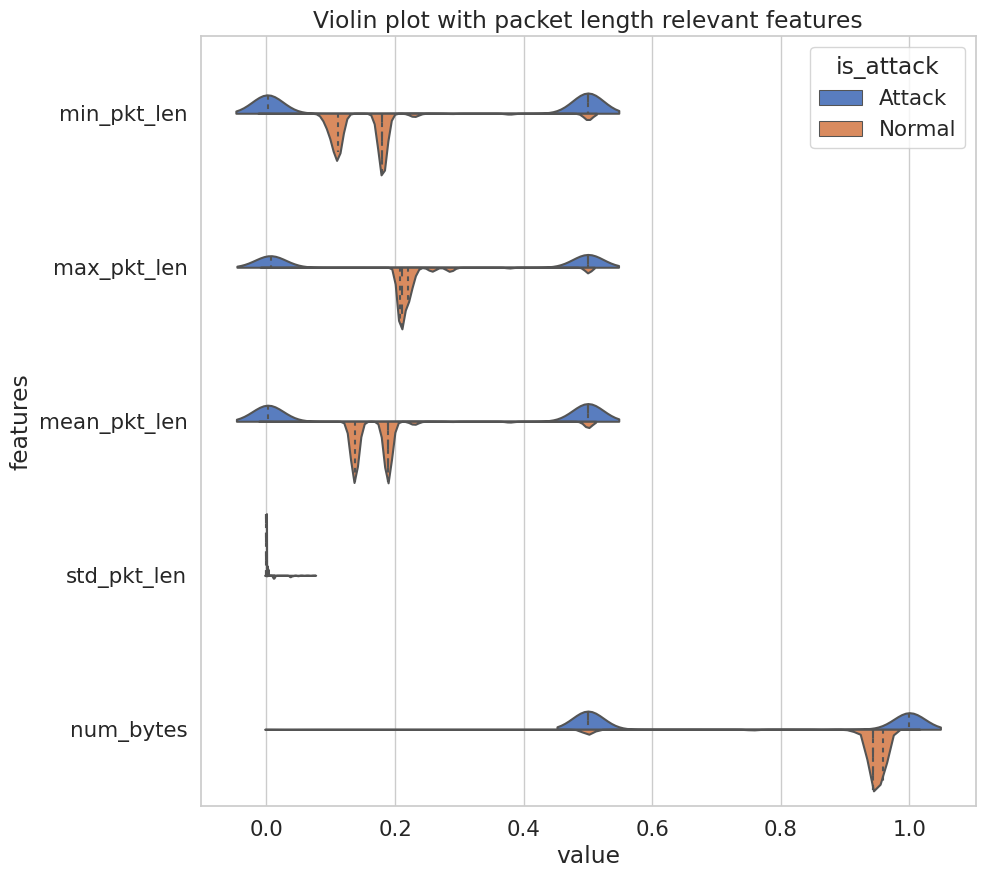

In [67]:
# Packet length relevant features
temp_data = pd.concat([y,scaled_x[['min_pkt_len', 'max_pkt_len', 'mean_pkt_len', 'std_pkt_len', 'num_bytes']]],axis=1)
temp_data = pd.melt(temp_data,id_vars="is_attack",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="is_attack", data=temp_data,split=True, inner="quart")
plt.title("Violin plot with packet length relevant features")
plt.show()

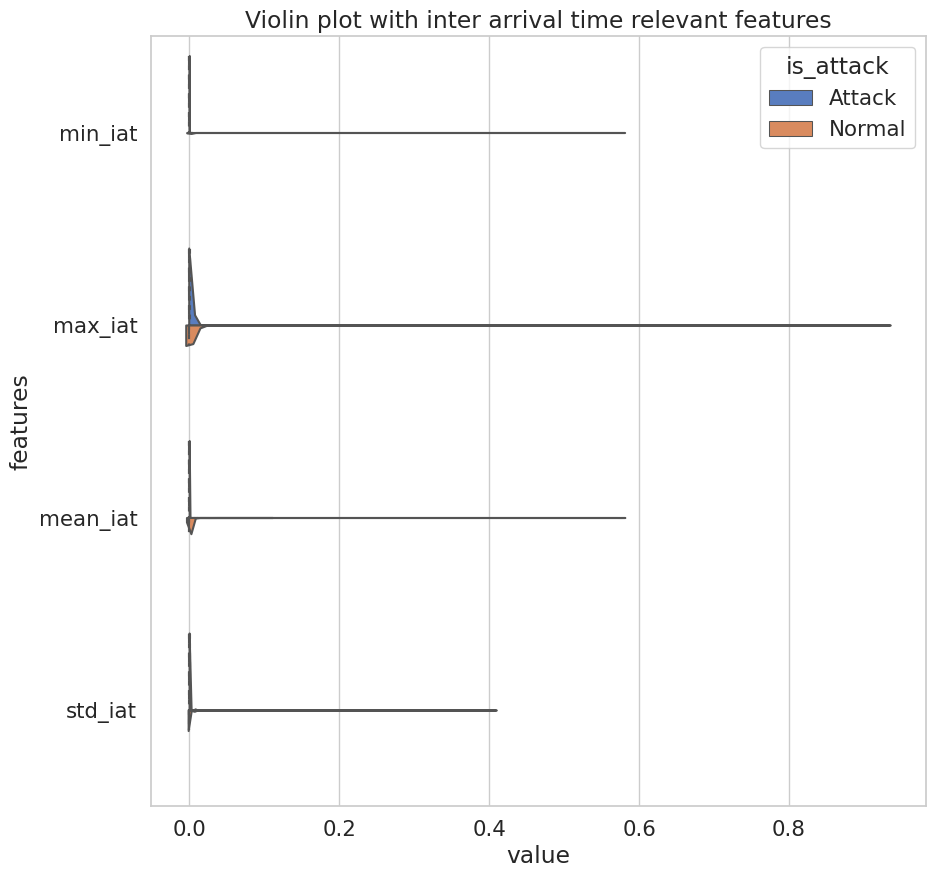

In [69]:
# Inter arrival time relevant features
temp_data = pd.concat([y,scaled_x[['min_iat', 'max_iat', 'mean_iat', 'std_iat']]],axis=1)
temp_data = pd.melt(temp_data,id_vars="is_attack",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="is_attack", data=temp_data,split=True, inner="quart")
plt.title("Violin plot with inter arrival time relevant features")
plt.show()

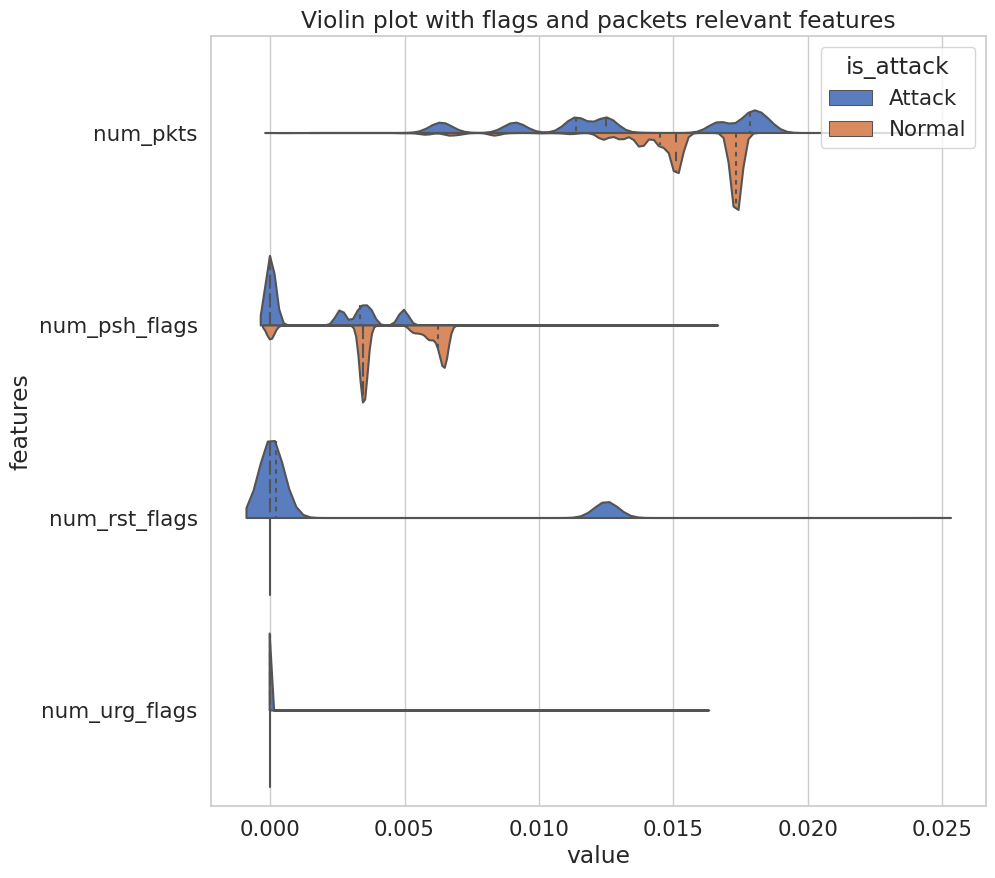

In [70]:
# Flags and packets relevant features
temp_data = pd.concat([y,scaled_x[['num_pkts', 'num_psh_flags', 'num_rst_flags', 'num_urg_flags']]],axis=1)
temp_data = pd.melt(temp_data,id_vars="is_attack",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="value", y="features", hue="is_attack", data=temp_data,split=True, inner="quart")
plt.title("Violin plot with flags and packets relevant features")
plt.show()

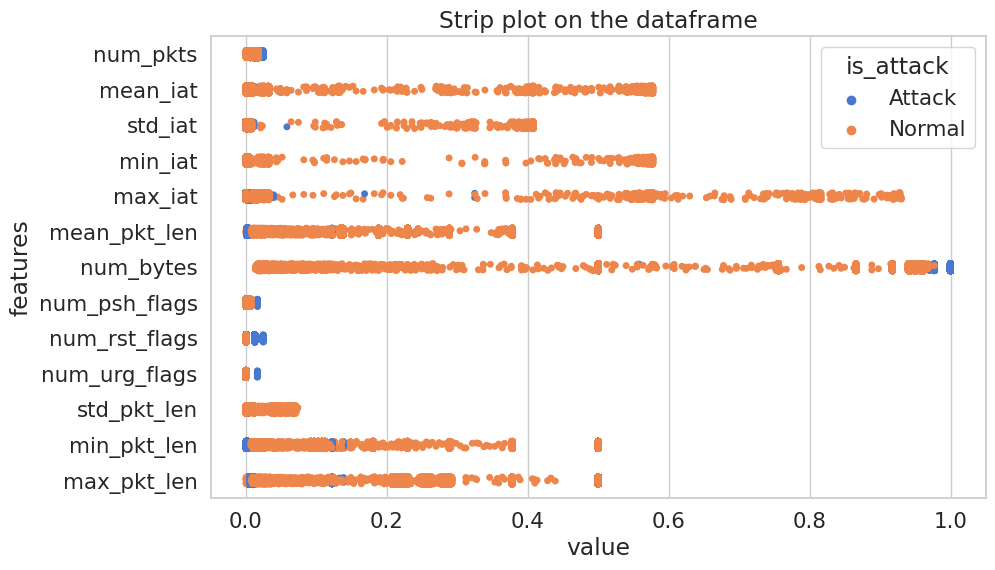

In [5]:
temp_data = pd.concat([y,scaled_x],axis=1)
temp_data = pd.melt(temp_data,id_vars="is_attack",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,6))
sns.stripplot(x="value", y="features", hue="is_attack", data=temp_data)
plt.title("Strip plot on the dataframe")
plt.show()

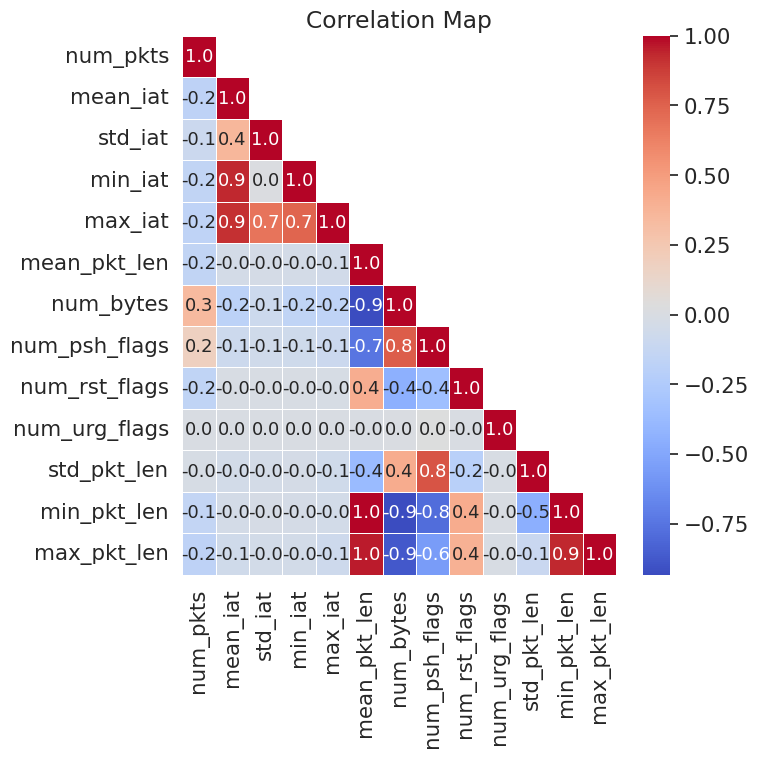

In [37]:
#correlation map .corr() has default the pearson coefficient
sns.set(style='white',font_scale = 1.4)
mask = np.triu(np.ones_like(scaled_x.corr(), dtype=bool))
np.fill_diagonal(mask, False)

f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(scaled_x.corr(),mask=mask,annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap= 'coolwarm',annot_kws={'size': 13})
plt.title('Correlation Map')
plt.show()

### MI score on  unscaled data

- Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
- Only `num_urg_flags` has a value of zero between the features

- Here are some things to consider when applying mutual information:

    1. MI can help to understand the relative potential of a feature as a predictor of the target, considered by itself.
    2. It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
    3. The actual usefulness of a feature depends on the model with which it will be used. A feature is only useful to the extent that its relationship with the target is one the model can learn. Just because a feature has a high MI score doesn't mean the model will be able to do anything with that information. The feature may need to be transformed first to expose the association.

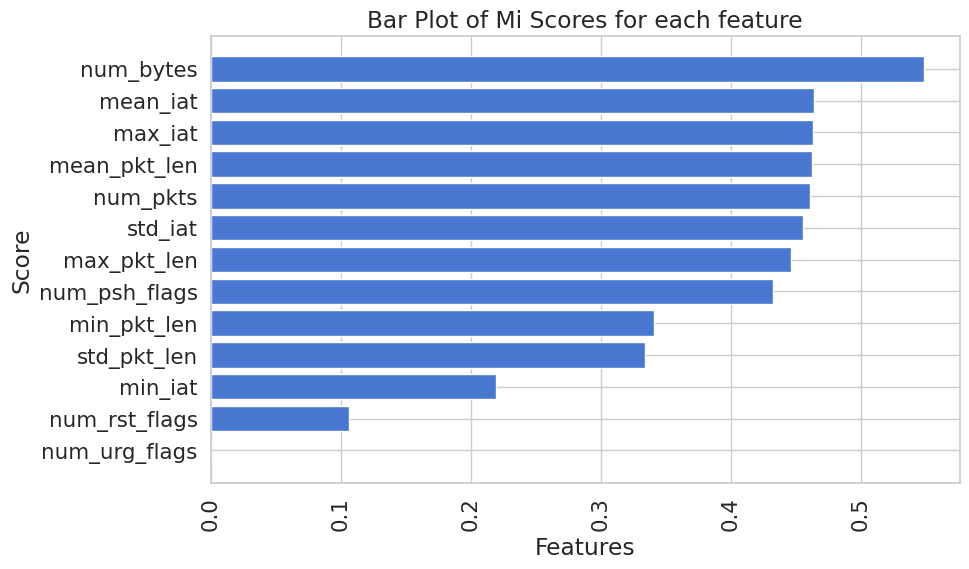

In [25]:
miscores = mutual_info_classif(x, y)
miscores_df = pd.Series(miscores, name="MI Scores", index=x.columns)
plt.figure(figsize=(10,6))
plt.barh(miscores_df.sort_values().index, miscores_df.sort_values().values)
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Bar Plot of Mi Scores for each feature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Feature selection

**Evaluation metric**
* The $F_1$ metric combines precision and recall.

* Mathematically, it is the *harmonious mean* of precision and recall.

* The harmonic mean of $n$ numbers $x_1, x_2, \ldots, x_n$ is defined as:

$$H={\frac {n}{{\frac {1}{x_{1}}}+{\frac {1}{x_{2}}}+\cdots +{\frac {1}{x_{n}}}}}$$

* Thus, the $F_1$ metric is:

$$F_{1}=2\cdot \frac{1}{\tfrac{1}{\mathrm{precision}}+\tfrac{1}{\mathrm{recall}}} = 2\cdot {\frac{ \mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} +\mathrm{recall}}}$$

* The $F_1$ metric will be used instead of the simple mean because it penalizes outliers.

* If either recall or precision is zero, the $F_1$ metric will be zero.

### with Random Forest classifier

#### by correlation
- F1 score for all the features: 0.9991 (+/- 0.0002)
- F1 score after droping correlated features over $r = 0.95$: 0.9992 (+/- 0.0002)

In [60]:
drop_new = corrX(x, cut = 0.95)
x_uncorrelated = x.drop(drop_new, axis=1)
print("Correlated features over 0.95 : ",len(drop_new),drop_new)

drop_new = corrX(x, cut = 0.8)
x_uncorrelated = x.drop(drop_new, axis=1)
print("Correlated features over 0.8 : ",len(drop_new),drop_new)

Correlated features over 0.95 :  2 ['mean_iat', 'max_pkt_len']
Correlated features over 0.8 :  3 ['mean_iat', 'std_pkt_len', 'max_pkt_len']


In [5]:
cross_val_print_f1(x,y)

F1 score is 0.9991 (+/- 0.0002)


In [6]:
x_selected = x.drop(['mean_iat', 'max_pkt_len'], axis=1)

In [7]:
cross_val_print_f1(x_selected,y)

F1 score is 0.9992 (+/- 0.0002)


#### by MI score
- Drop the feature with MI score = 0, which is `num_urg_flags`
- F1 score is $0.9991$

In [79]:
x_selected = x.drop('num_urg_flags', axis=1)

In [80]:
cross_val_print_f1(x_selected,y)

F1 score is 0.999 (+/- 0.000)


#### with univariate feature selection (SelectKbest)
- `sklearn`'s `SelectKBest` is removing all but the $k$ highest-scoring features
- In this method exhaustive (GridSearchCV) will be used to find the optimal number of $k$
- Even with this method after selecting the $12$ best features we are getting F1 score as before $0.9991$

In [ ]:
# https://www.yourdatateacher.com/2021/04/26/feature-selection-via-grid-search-in-supervised-models/

pipeline = Pipeline([('scaler', preprocessing.FunctionTransformer(preprocessing.normalize)),('selector',SelectKBest(f_classif)),('model',RandomForestClassifier(random_state = 13))])
cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=1 , random_state=13)

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {
  'selector__k': list(range(1, 13)) 
 },
    n_jobs=-1,
    scoring="f1_macro",
    cv=cv,
    verbose=0
)
search.fit(x,y)
search.best_params_

In [4]:
# find best scored 12 features
select_feature = SelectKBest(f_classif, k=12).fit(x, y)

# Get columns to keep and create new dataframe with those only
cols = select_feature.get_support(indices=True)
x_kbest = x.iloc[:,cols]

In [5]:
print('Selected feature list:', x_kbest.columns)

Selected feature list: Index(['num_pkts', 'std_iat', 'min_iat', 'max_iat', 'mean_pkt_len',
       'num_bytes', 'num_psh_flags', 'num_rst_flags', 'num_urg_flags',
       'std_pkt_len', 'min_pkt_len', 'max_pkt_len'],
      dtype='object')


In [6]:
cross_val_print_f1(x_kbest,y)

F1 score is 0.999 (+/- 0.000)


#### with recursive feature elimination (rfe)
- We can also see that the F1 Score remains the same $0.9991$

In [7]:
# Create the RFE object and rank each pixel  
rfe = RFE(estimator=RandomForestClassifier(random_state=13), n_features_to_select=12, step=1)
rfe = rfe.fit(x, y)

In [9]:
print('Chosen best',rfe.n_features_,'feature by rfe:',x.columns[rfe.support_])
print("Feature Ranking: " , rfe.ranking_)

Chosen best 12 feature by rfe: Index(['num_pkts', 'mean_iat', 'std_iat', 'min_iat', 'max_iat', 'mean_pkt_len',
       'num_bytes', 'num_psh_flags', 'num_rst_flags', 'std_pkt_len',
       'min_pkt_len', 'max_pkt_len'],
      dtype='object')
Feature Ranking:  [1 1 1 1 1 1 1 1 1 2 1 1 1]


In [10]:
x_rfe = rfe.transform(x)

# Cross validate RFE
cross_val_print_f1(x_rfe,y)

F1 score is 0.999 (+/- 0.000)


#### with recursive feature elimination with cross validation (rfecv)
- We can also see that the F1 Score remains the same $0.9991$

In [8]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier(random_state=13)
cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=1 , random_state=13)
rfecv = RFECV(estimator=clf_rf_4,min_features_to_select=1, step=1, cv=cv,scoring='f1_macro')
rfecv = rfecv.fit(x, y)


In [12]:

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x.columns[rfecv.support_])

Optimal number of features : 11
Best features : Index(['num_pkts', 'mean_iat', 'std_iat', 'min_iat', 'max_iat', 'mean_pkt_len',
       'num_bytes', 'num_psh_flags', 'std_pkt_len', 'min_pkt_len',
       'max_pkt_len'],
      dtype='object')


In [9]:
x_rfecv = rfecv.transform(x)
  
# Cross validate RFECV
cross_val_print_f1(x_rfecv,y)

F1 score is 0.9991 (+/- 0.0002)


Optimal number of features : 11


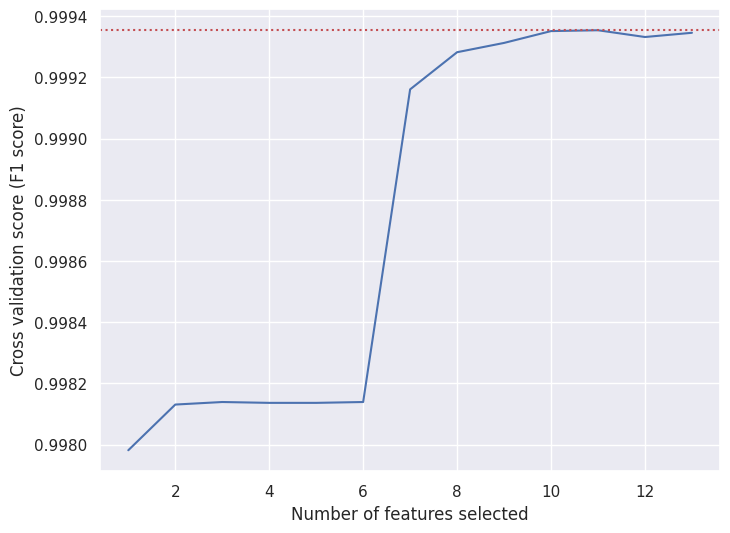

In [16]:
# Plot number of features VS. cross-validation scores
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation 
sns.set(font_scale = 1)
plt.figure(figsize=(8,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (F1 score)")
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
)
plt.axhline(y=rfecv.cv_results_['mean_test_score'].max(), color='r', linestyle='dotted',alpha=1)
plt.show()

### Feature importances with a forest of trees
* In the random forest classification method there is an attribute **feature_importances_** which is the importance of the features (the higher, the more important the feature). *!!! To use the feature_importance method, there should be no corellated features in the training data. The random forest selects randomly in each iteration, so the order of the feature importance list may change.*

- F1 score $0.9992$

In [ ]:
clf_rf_5 = RandomForestClassifier(random_state=13)      
clr_rf_5 = clf_rf_5.fit(x,y)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


Feature ranking:
1. feature 11 (0.173126)
2. feature 7 (0.144545)
3. feature 12 (0.141286)
4. feature 6 (0.131767)
5. feature 0 (0.086453)
6. feature 5 (0.085099)
7. feature 3 (0.066569)
8. feature 4 (0.056733)
9. feature 2 (0.056377)
10. feature 1 (0.040908)
11. feature 10 (0.017094)
12. feature 8 (0.000036)
13. feature 9 (0.000006)


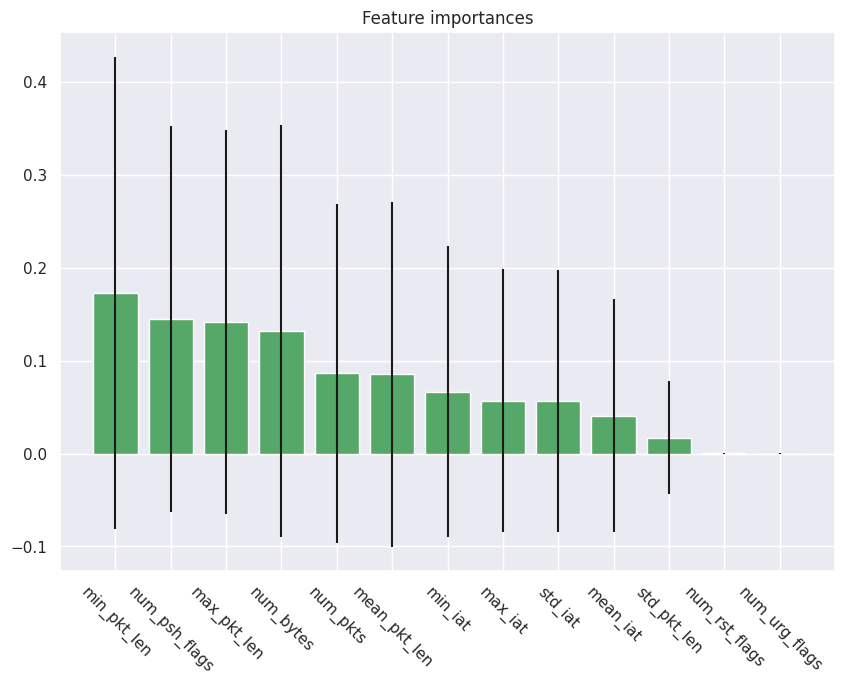

In [12]:
# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
sns.set(font_scale = 1)
plt.figure(1, figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=-45)
plt.xlim([-1, x.shape[1]])
plt.show()

In [10]:
x_rf_importances = x[['min_pkt_len','num_psh_flags','max_pkt_len','num_bytes', 'num_pkts', 'mean_pkt_len','min_iat','max_iat','std_iat', 'mean_iat', 'std_pkt_len']]

# Cross validate Random forest feature importances
cross_val_print_f1(x_rf_importances,y)

F1 score is 0.9992 (+/- 0.0002)


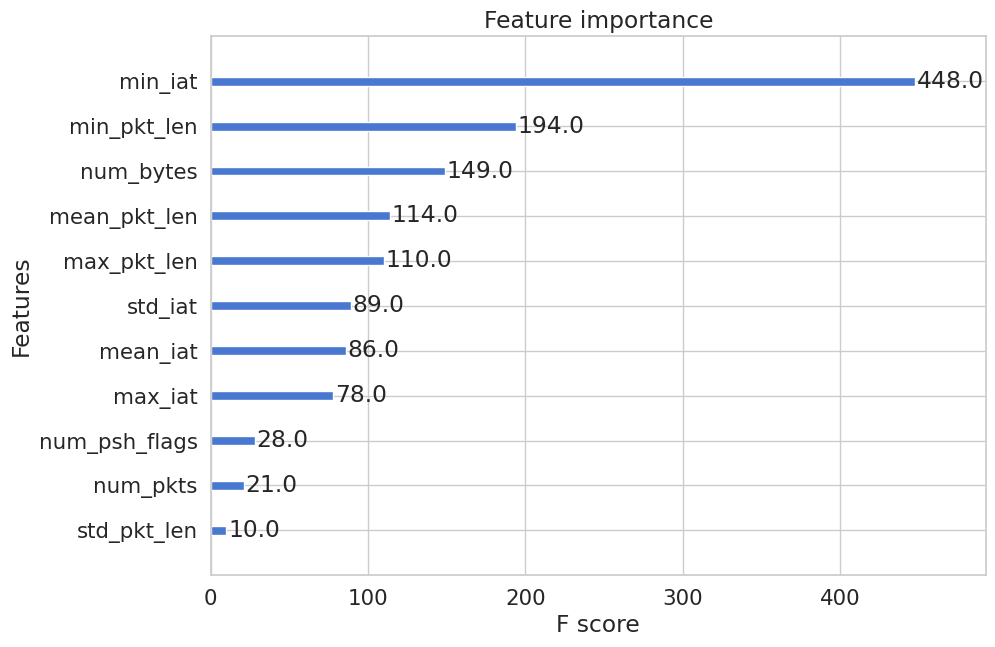

In [22]:
le= LabelEncoder()
le.fit(y)
y_le = le.transform(y)
# fit model no training data
model = XGBClassifier()
model.fit(x, y_le)
# plot feature importance\
plt.rcParams["figure.figsize"] = (10, 7)
plot_importance(model,importance_type='weight')
sns.set(font_scale = 1)
plt.show()

### XGBoost 
F1 score is 0.9518 (+/- 0.0013)

In [11]:
x_xgb_importances = x[['mean_iat', 'std_iat', 'min_iat', 'max_iat', 'mean_pkt_len', 'num_bytes', 'num_rst_flags', 'num_urg_flags', 'min_pkt_len', 'max_pkt_len']]

# Cross validate XGBoost feature importances
cross_val_print_f1(x_xgb_importances,y)

F1 score is 0.9518 (+/- 0.0013)


### Minimum Redundance & Maximum Relevance
- F1 Score is $0.9992$

In [14]:
from mrmr import mrmr_classif
y_mrmr = pd.Series(y)
mrmr_features = mrmr_classif(x, y_mrmr, K=10)

100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


In [15]:
x_mrmr = x[mrmr_features]
cross_val_print_f1(x_mrmr,y)

F1 score is 0.9992 (+/- 0.0002)


In [32]:
mrmr_features

['num_psh_flags',
 'min_pkt_len',
 'num_pkts',
 'num_rst_flags',
 'max_pkt_len',
 'std_pkt_len',
 'max_iat',
 'std_iat',
 'num_urg_flags',
 'num_bytes']

## Summary
- First of all there is no need for feature extraction with techincs that change the whole dataset, like PCA, because we need to keep the preprocessing as small as possible in order to use our predictions in real-time.
- As it turned out, the feature exctraction on this specific problem was unneeded. Because in the end the F1 score was already great from the begging and didn't improved. 
- Also there was so little space for improving the F1 Score as it was already at $0.999$
- The machine learning models that are going to be built are going to use all the features from the final dataset.